In [123]:
steps=1000
learning_rate = 0.005
expected_cost = 0.01

In [170]:
import numpy as np
import tensorflow as tf
import random


######################################################################
NR_SAMPLES_PER_HOUR = 6
# 10 minutes
MINUTES_BETWEEN_SAMPLES = 60 / NR_SAMPLES_PER_HOUR

def cpu_stats():
    def random_list(start, stop, length):
        return [random.randrange(start, stop) / 100.0 for i in range(length)]
    stats = []
    hours = range(0, 5)
    stats.extend(random_list(5, 20, NR_SAMPLES_PER_HOUR * len(hours)))
    hours = range(5, 19)
    stats.extend(random_list(80, 98, NR_SAMPLES_PER_HOUR * len(hours)))
    hours = range(19, 24)
    stats.extend(random_list(2, 10, NR_SAMPLES_PER_HOUR * len(hours)))
    return stats

def uniform_list(L):
    length = len(L)
    return [float(i)/(length - 1) for i in L]

######################################################################

stats = cpu_stats()

train_x = np.array(uniform_list(range(len(stats))))
train_y = np.array(stats)

W = tf.Variable(tf.random_uniform([1]))
B = tf.Variable(tf.zeros([1]))
Y = W * train_x + B

cost = tf.reduce_mean(tf.square(Y - train_y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

train = optimizer.minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(steps):
    sess.run(train)
    if i % 20 == 0:
        curr_cost = sess.run(cost)
        print 'step %5d: cost %.16f' % (i, curr_cost)
        if curr_cost < expected_cost:
            print 'OK.'
            break

curr_w = sess.run(W)
curr_b = sess.run(B)
print 'Train: W=%f, B=%f' % (curr_w, curr_b)

step     0: cost 0.2506578862667084
step    20: cost 0.2474405020475388
step    40: cost 0.2446162104606628
step    60: cost 0.2420514374971390
step    80: cost 0.2396652996540070
step   100: cost 0.2374086678028107
step   120: cost 0.2352514564990997
step   140: cost 0.2331750690937042
step   160: cost 0.2311677336692810
step   180: cost 0.2292218953371048
step   200: cost 0.2273324280977249
step   220: cost 0.2254958450794220
step   240: cost 0.2237094193696976
step   260: cost 0.2219711840152740
step   280: cost 0.2202793508768082
step   300: cost 0.2186324149370193
step   320: cost 0.2170290648937225
step   340: cost 0.2154680937528610
step   360: cost 0.2139482498168945
step   380: cost 0.2124684602022171
step   400: cost 0.2110276520252228
step   420: cost 0.2096247822046280
step   440: cost 0.2082588374614716
step   460: cost 0.2069288343191147
step   480: cost 0.2056338489055634
step   500: cost 0.2043729424476624
step   520: cost 0.2031452208757401
step   540: cost 0.201949775

In [171]:
def y_fn(x):
    # y = w*x + b
    return x * curr_w + curr_b

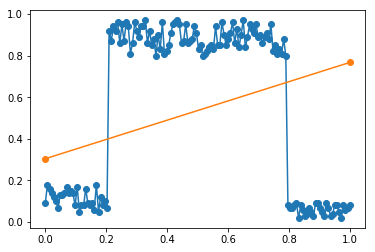

In [172]:
import matplotlib.pyplot as plt
%matplotlib inline  

x = np.array(train_x)
y = np.array(train_y)

line_x = [0.0, 1.0]
line_y = [y_fn(0.0), y_fn(1.0)]

#print x
#print y
#print line_x
#print line_y

plt.plot(x, y, line_x, line_y, marker = 'o')

plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


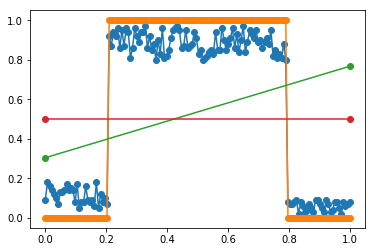

In [173]:
x = np.array(train_x)
y = np.array(train_y)

force_idle_threshold = 0.5 # 50%
# busy: 1, idle: 0
y2 = np.array([1 if i > y_fn(i) and i > force_idle_threshold else 0 for i in train_y])

threshold_x = [0.0, 1.0]
threshold_y = [force_idle_threshold, force_idle_threshold]
print y2

plt.plot(x, y, x, y2, line_x, line_y, threshold_x, threshold_y, marker = 'o')

plt.show()

In [174]:
def collect_idle_time_windows(stats):
    time_windows = {}
    nr_idle = 0
    for index, value in enumerate(stats):
        if value == 0:
            nr_idle += 1
        else:
            if nr_idle > 0:
                # key: start sample index
                # value: number of idle samples
                time_windows[index - nr_idle] = nr_idle
                nr_idle = 0
    else:
        if nr_idle > 0:
            time_windows[index - nr_idle] = nr_idle
    # sort by value from max to min
    # returns: [(k1,v1), (k2,v2), ...]
    return sorted(time_windows.items(), key=lambda item: item[1], reverse=True)


def show_idle_time_windows(idle_time_window):
    print("\nidle time windows details:")
    for t in idle_time_window:
        start_hour = int(t[0] / NR_SAMPLES_PER_HOUR)
        start_minute = (t[0] % NR_SAMPLES_PER_HOUR) * MINUTES_BETWEEN_SAMPLES
        end_hour = int((t[0] + t[1]) / NR_SAMPLES_PER_HOUR)
        end_minute = ((t[0] + t[1]) % NR_SAMPLES_PER_HOUR) * MINUTES_BETWEEN_SAMPLES
        print("{:>02d}:{:>02d} ~ {:>02d}:{:>02d} -> {:<3d} minutes".format(start_hour, start_minute, end_hour, end_minute, MINUTES_BETWEEN_SAMPLES * t[1]))
        


time_windows = collect_idle_time_windows(y2)
print 'idle time windows:', time_windows

show_idle_time_windows(time_windows)

idle time windows: [(0, 30), (113, 30)]

idle time windows details:
00:00 ~ 05:00 -> 300 minutes
18:50 ~ 23:50 -> 300 minutes
